In [44]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.options.display.max_rows = 3000


def my_remove_highly_correlated(X,threshold):

    X = X.select_dtypes(include=[np.number])  #.dropna()
    
    cols = X.columns

    #run correlation matrix
    df = X.corr()
   
    #put df into array
    a = df.values
    
    #label top half with -99999 
    #we want to ignore top half of matrix
    iu1 = np.triu_indices(len(df))
    a[iu1] = -99999
    #put data back into dataframe
    df = pd.DataFrame(a, columns=cols)
    df['var'] = cols
    
    #unstack to get a list of var1, var2, correlation
    df = pd.melt(df, id_vars=['var'])
        
    #remove those flagged with -99999
    df = df[df.value != -99999].sort_values(by='var', ascending=True)
  
    #flag remove vs keep based on corr threshold
    df_remove = df[df.value > threshold]
    remove_list = df_remove['var'].unique()
 
    print('{} out of {} vars removed due to corr greater than {}'.
          format(df_remove.shape[0],X.shape[1],threshold))
    
    new_df = X.drop(columns=remove_list, axis=1)
    
    print(df_remove)
    print('\nShape before: ' + str(X.shape))
    print('Shape after: ' + str(new_df.shape))
    print('\n')
    return new_df

def my_drop_na_columns(X,NANthreshold):

    df = X
    colcount = df.shape[1]
    #Get count of NA in each column
    series_cols = df.isnull().sum(axis = 0).sort_values(ascending=False)

    #filter the list to include only those with counts above threshold
    series_cols_remove = series_cols[series_cols.values >= NANthreshold]
    series_cols_keep = series_cols[(series_cols.values < NANthreshold) & (series_cols.values > 0) ]
    
    #put the to-remove column names in a list
    list_colstodrop = series_cols_remove.index.tolist()

    #drop the columns
    df = df.drop(labels = list_colstodrop, axis=1)

    #print the results
    print('Flagged {} of {} Columns - containing more than {} NANs\n'.format(
          series_cols_remove.shape[0],colcount,NANthreshold))
    print(series_cols_remove)
    
    print('\n{} Columns remain with NANs\n'.format(series_cols_keep.shape[0]))
    print(series_cols_keep)
    print('\nShape before: ' + str(X.shape))
    print('Shape after: ' + str(df.shape))
    print('\n')    
    return df


def my_confusion_matrix(array_Expected,array_Predicted,colName):
    a = np.array(confusion_matrix(array_Expected, array_Predicted ))
    totalExpectedFalse = a[0,0] + a[0,1]
    totalExpectedTrue = a[1,0] + a[1,1]
    correctFalse = a[0,0] 
    correctTrue = a[1,1] 
    correctTruePct = np.round(correctTrue / totalExpectedTrue,3)
    correctFalsePct = np.round(correctFalse / totalExpectedFalse,3)
    print('Regarding ' + colName + '...')
    print('The model correctly predicted {} Negatives out of {} expected Negatives: {}'.format(
        correctFalse,totalExpectedFalse,correctFalsePct))
    print('The model correctly predicted {} Positives out of {} expected Positives: {}'.format(
        correctTrue,totalExpectedTrue,correctTruePct))    
    print(a)


def my_show_feature_importance(feature_importances, X):

    # Make importances relative to max importance.
    feature_importances = 100.0 * (feature_importances / feature_importances.max())
    
    sorted_idx = np.argsort(feature_importances)
    
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(10,8))
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importances[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()


In [4]:
raw_data = pd.read_csv('breast-cancer-wisconsin.data.txt')
raw_data.shape

(698, 11)

In [9]:
df = raw_data.copy()

#Name the columns
col_names = [
'id number',
'Clump_Thickness',# 1 - 10 
'Uniformity_of_Cell_Size',# 1 - 10 
'Uniformity_of_Cell_Shape',# 1 - 10 
'Marginal_Adhesion',# 1 - 10 
'Single_Epithelial_Cell_Size',# 1 - 10 
'Bare_Nuclei',# 1 - 10 
'Bland_Chromatin',# 1 - 10 
'Normal_Nucleoli',# 1 - 10 
'Mitoses',# 1 - 10 
'Class',# (2 for benign, 4 for malignant)
]

df.columns = col_names

#Binarize the Target variable
df['Class_Malignant'] = np.where(df.Class == 4, 1, 0)
df.drop(columns=['Class'], inplace=True)

##Check for nulls
df = my_drop_na_columns(df, 100)

df.head()

Dropped 0 of 11 Columns - containing more than 100 NANs

Series([], dtype: int64)

0 Columns remain with NANs

Series([], dtype: int64)

Shape before: (698, 11)
Shape after: (698, 11)




,id number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class_Malignant
0,1002945,5,4,4,5,7,10,3,2,1,0
1,1015425,3,1,1,1,2,2,3,1,1,0
2,1016277,6,8,8,1,3,4,3,7,1,0
3,1017023,4,1,1,3,2,1,3,1,1,0
4,1017122,8,10,10,8,7,10,9,7,1,1


In [12]:
#Review Data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id number,698.0,1.071807e+06,617532.274029,61634.0,870258.25,1171710.0,1238354.0,13454352.0
Clump_Thickness,698.0,4.416905e+00,2.817673,1.0,2.00,4.0,6.0,10.0
Uniformity_of_Cell_Size,698.0,3.137536e+00,3.052575,1.0,1.00,1.0,5.0,10.0
Uniformity_of_Cell_Shape,698.0,3.210602e+00,2.972867,1.0,1.00,1.0,5.0,10.0
Marginal_Adhesion,698.0,2.809456e+00,2.856606,1.0,1.00,1.0,4.0,10.0
Single_Epithelial_Cell_Size,698.0,3.217765e+00,2.215408,1.0,2.00,2.0,4.0,10.0
Bland_Chromatin,698.0,3.438395e+00,2.440056,1.0,2.00,3.0,5.0,10.0
Normal_Nucleoli,698.0,2.869628e+00,3.055004,1.0,1.00,1.0,4.0,10.0
Mitoses,698.0,1.590258e+00,1.716162,1.0,1.00,1.0,1.0,10.0
Class_Malignant,698.0,3.452722e-01,0.475798,0.0,0.00,0.0,1.0,1.0


In [30]:
#Split data into features X and target y
y = df.Class_Malignant
X = df.drop(columns=['Class_Malignant','id number'], axis=1)

#Remove Highlight Correlated features
X = my_remove_highly_correlated(X=X, threshold=.90)

#X = my_minmax_scaler(X, 0, 1)

print(y.shape)
print(X.shape)

1 out of 8 vars removed due to corr greater than 0.9
                         var                 variable     value
10  Uniformity_of_Cell_Shape  Uniformity_of_Cell_Size  0.906814

Shape before: (698, 8)
Shape after: (698, 7)


(698,)
(698, 7)
CPU times: user 11.5 ms, sys: 1.31 ms, total: 12.8 ms
Wall time: 11.6 ms


In [31]:
#Split data into folds for testing
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits=5, test_size=.2)
skf.get_n_splits(X, y)

5

In [52]:
#------  GRID SEARCH:  RANDOM FOREST -------
#-------------------------------------------
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

model = ensemble.RandomForestClassifier(n_estimators=1000, max_depth=30, max_features=3 )

#Random Forest Parameters
n_estimators = [500,1500,3000]
max_depth = [5,10,15]
max_features = [1,3]


param_grid = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'max_features': max_features}

grid_search = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=3,
                  return_train_score=False)
grid_search.fit(X, y)
grid_results_random_forest = pd.DataFrame(grid_search.cv_results_)
grid_results_random_forest.drop(columns=['params']).sort_values(by='mean_test_score', ascending=False)

grid_results_random_forest.drop(columns=['params']).sort_values(by='mean_test_score', ascending=False)
#Best params =  max_depth=5, max_features=1, n_estimators=3000

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,2.830831,0.048063,0.175454,0.005378,5,1,3000,0.935897,0.952586,0.982759,0.957020,0.019398,1
1,1.337860,0.013798,0.089778,0.004797,5,1,1500,0.935897,0.952586,0.982759,0.957020,0.019398,1
0,0.461134,0.007185,0.028898,0.000465,5,1,500,0.935897,0.952586,0.978448,0.955587,0.017512,3
8,2.745703,0.058981,0.180551,0.003261,10,1,3000,0.935897,0.948276,0.982759,0.955587,0.019827,3
14,2.781769,0.033083,0.182909,0.002433,15,1,3000,0.931624,0.948276,0.982759,0.954155,0.021298,5
13,1.429993,0.020619,0.093130,0.001766,15,1,1500,0.931624,0.948276,0.982759,0.954155,0.021298,5
7,1.359694,0.011935,0.088536,0.001761,10,1,1500,0.931624,0.943966,0.982759,0.952722,0.021785,7
12,0.470459,0.009195,0.039518,0.012206,15,1,500,0.931624,0.939655,0.982759,0.951289,0.022445,8
5,2.861083,0.023892,0.171083,0.001261,5,3,3000,0.918803,0.952586,0.982759,0.951289,0.026144,8
6,0.459581,0.008783,0.030459,0.000947,10,1,500,0.931624,0.939655,0.982759,0.951289,0.022445,8


---------------------------------------
---------- Random Forest --------------
---------------------------------------
---------- Strata # 1--------------
Test Set Accuracy: 0.9785714285714285
Regarding Malignancy...
The model correctly predicted 92 Negatives out of 92 expected Negatives: 1.0
The model correctly predicted 45 Positives out of 48 expected Positives: 0.938
[[92  0]
 [ 3 45]]
---------- Strata # 2--------------
Test Set Accuracy: 0.9357142857142857
Regarding Malignancy...
The model correctly predicted 86 Negatives out of 92 expected Negatives: 0.935
The model correctly predicted 45 Positives out of 48 expected Positives: 0.938
[[86  6]
 [ 3 45]]
---------- Strata # 3--------------
Test Set Accuracy: 1.0
Regarding Malignancy...
The model correctly predicted 92 Negatives out of 92 expected Negatives: 1.0
The model correctly predicted 48 Positives out of 48 expected Positives: 1.0
[[92  0]
 [ 0 48]]
---------- Strata # 4--------------
Test Set Accuracy: 0.9571428571428572
Re

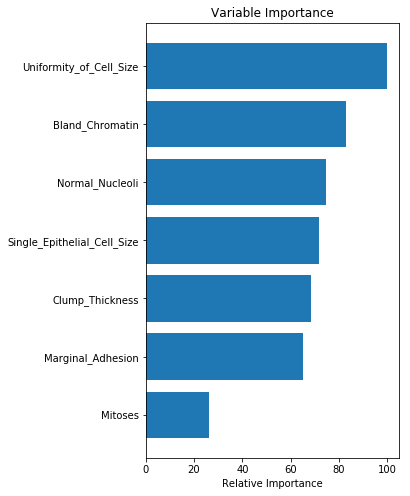

CPU times: user 15.8 s, sys: 70.6 ms, total: 15.8 s
Wall time: 15.6 s


In [45]:
%%time
#------  DISPLAY TYPE I and TYPE 2 RESULTS:  RANDOM FOREST -------
#-----------------------------------------------------------------
from sklearn import ensemble


model = ensemble.RandomForestClassifier(n_estimators=3000, max_depth=5, max_features=1 )

i = 1
print ('---------------------------------------')
print ('---------- Random Forest --------------')
print ('---------------------------------------')
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('---------- Strata # ' + str(i) + '--------------')
    print('Test Set Accuracy: ' + str(model.score(X_test, y_test)))
    my_confusion_matrix(y_test, y_pred, 'Malignancy')
    i = i + 1

my_show_feature_importance(model.feature_importances_, X_train)

In [42]:
#------  GRID SEARCH:  K NEAREST NEIGHBOR -------
#-----------------------------------------------
from sklearn.neighbors import KNeighborsClassifier

#KNN Parameters
n_neighbors = [10,20,30,40,50]
weights = ['distance','uniform']


param_grid = {'n_neighbors': n_neighbors,
             'weights': weights}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3,
                  return_train_score=False)
grid_search.fit(X, y)
grid_results = pd.DataFrame(grid_search.cv_results_)

grid_results.drop(columns=['params']).sort_values(by='mean_test_score', ascending=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.000964,0.000036,0.001362,0.000040,10,uniform,0.935897,0.943966,0.982759,0.954155,0.020450,1
3,0.000909,0.000019,0.001640,0.000068,20,uniform,0.927350,0.952586,0.982759,0.954155,0.022663,1
6,0.000922,0.000019,0.002149,0.000020,40,distance,0.923077,0.948276,0.987069,0.952722,0.026331,3
0,0.001183,0.000341,0.001528,0.000115,10,distance,0.927350,0.943966,0.982759,0.951289,0.023219,4
2,0.000941,0.000022,0.001688,0.000042,20,distance,0.923077,0.948276,0.982759,0.951289,0.024475,4
4,0.000897,0.000007,0.001901,0.000037,30,distance,0.923077,0.948276,0.982759,0.951289,0.024475,4
5,0.000919,0.000003,0.001862,0.000070,30,uniform,0.918803,0.948276,0.982759,0.949857,0.026152,7
7,0.000940,0.000035,0.002116,0.000064,40,uniform,0.914530,0.943966,0.987069,0.948424,0.029801,8
8,0.001128,0.000109,0.002913,0.000411,50,distance,0.910256,0.943966,0.987069,0.946991,0.031453,9
9,0.001276,0.000139,0.002953,0.000117,50,uniform,0.910256,0.939655,0.987069,0.945559,0.031656,10


In [46]:
#------  DISPLAY TYPE I and TYPE 2 RESULTS:  K NEAREST NEIGHBOR -------
#-----------------------------------------------------------------
i = 1
model = KNeighborsClassifier(n_neighbors=10, weights='uniform')

print ('---------------------------------------')
print ('---------- K Nearest Neighbor --------------')
print ('---------------------------------------')
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('---------- Strata # ' + str(i) + '--------------')
    my_confusion_matrix(y_test, y_pred, 'Malignancy')
    i = i + 1

---------------------------------------
---------- K Nearest Neighbor --------------
---------------------------------------
---------- Strata # 1--------------
Regarding Malignancy...
The model correctly predicted 90 Negatives out of 92 expected Negatives: 0.978
The model correctly predicted 44 Positives out of 48 expected Positives: 0.917
[[90  2]
 [ 4 44]]
---------- Strata # 2--------------
Regarding Malignancy...
The model correctly predicted 87 Negatives out of 92 expected Negatives: 0.946
The model correctly predicted 46 Positives out of 48 expected Positives: 0.958
[[87  5]
 [ 2 46]]
---------- Strata # 3--------------
Regarding Malignancy...
The model correctly predicted 88 Negatives out of 92 expected Negatives: 0.957
The model correctly predicted 43 Positives out of 48 expected Positives: 0.896
[[88  4]
 [ 5 43]]
---------- Strata # 4--------------
Regarding Malignancy...
The model correctly predicted 89 Negatives out of 92 expected Negatives: 0.967
The model correctly predi

In [47]:
#------  GRID SEARCH:  LOGISTIC REGRESSION -------
#-----------------------------------------------
from sklearn import linear_model 

#KNN Parameters
penalty = ['l2','l1']
C = [.001,.01,1,100,1000,10000]


param_grid = {'penalty': penalty,
             'C': C}

grid_search = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=3,
                  return_train_score=False)
grid_search.fit(X, y)
grid_results = pd.DataFrame(grid_search.cv_results_)

grid_results.drop(columns=['params']).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,0.003411,0.000141,0.000269,4.492277e-05,100,l1,0.923077,0.943966,0.982759,0.949857,0.024734,1
8,0.001613,0.000095,0.000214,5.550598e-06,1000,l2,0.923077,0.943966,0.982759,0.949857,0.024734,1
9,0.002657,0.000666,0.000209,3.339752e-06,1000,l1,0.923077,0.943966,0.982759,0.949857,0.024734,1
10,0.001449,0.000064,0.000208,7.867412e-07,10000,l2,0.923077,0.943966,0.982759,0.949857,0.024734,1
11,0.002587,0.000664,0.000202,7.786718e-07,10000,l1,0.923077,0.943966,0.982759,0.949857,0.024734,1
5,0.002170,0.000122,0.000205,1.752012e-06,1,l1,0.923077,0.939655,0.982759,0.948424,0.025155,6
6,0.001430,0.000062,0.000203,1.215701e-06,100,l2,0.918803,0.943966,0.982759,0.948424,0.026317,6
4,0.001335,0.000021,0.000204,1.189441e-06,1,l2,0.901709,0.948276,0.982759,0.944126,0.033241,8
2,0.001210,0.000093,0.000211,1.036930e-05,0.01,l2,0.833333,0.857759,0.952586,0.881089,0.051425,9
0,0.015574,0.020397,0.003554,4.730900e-03,0.001,l2,0.713675,0.711207,0.875000,0.766476,0.076580,10


---------------------------------------
---------- Logistic Regression --------------
---------------------------------------
---------- Strata # 1--------------
Regarding Malignancy...
The model correctly predicted 88 Negatives out of 92 expected Negatives: 0.957
The model correctly predicted 47 Positives out of 48 expected Positives: 0.979
[[88  4]
 [ 1 47]]
---------- Strata # 2--------------
Regarding Malignancy...
The model correctly predicted 90 Negatives out of 92 expected Negatives: 0.978
The model correctly predicted 44 Positives out of 48 expected Positives: 0.917
[[90  2]
 [ 4 44]]
---------- Strata # 3--------------
Regarding Malignancy...
The model correctly predicted 89 Negatives out of 92 expected Negatives: 0.967
The model correctly predicted 46 Positives out of 48 expected Positives: 0.958
[[89  3]
 [ 2 46]]
---------- Strata # 4--------------
Regarding Malignancy...
The model correctly predicted 91 Negatives out of 92 expected Negatives: 0.989
The model correctly pred

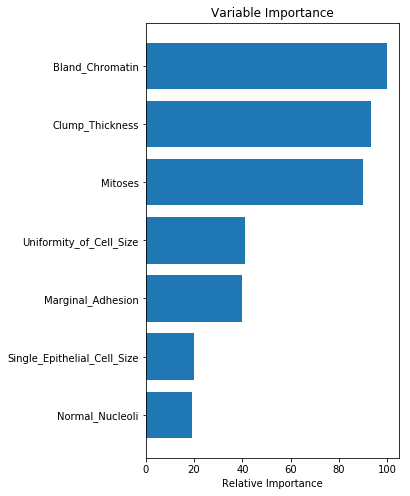

CPU times: user 429 ms, sys: 58.9 ms, total: 488 ms
Wall time: 215 ms


In [51]:
%%time
#------  DISPLAY TYPE I and TYPE 2 RESULTS:  LOGISTIC REGRESSION -------
#-----------------------------------------------------------------

model = linear_model.LogisticRegression(penalty='l1', C=100 )

i = 1
print ('---------------------------------------')
print ('---------- Logistic Regression --------------')
print ('---------------------------------------')
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('---------- Strata # ' + str(i) + '--------------')
    my_confusion_matrix(y_test, y_pred, 'Malignancy')
    coef = np.abs(model.coef_)
    coef = coef.reshape(coef.shape[1],)
    i = i + 1
    
my_show_feature_importance(coef,X_train)